Code for **"Blind restoration of a JPEG-compressed image"** and **"Blind image denoising"** figures. Select `fname` below to switch between the two.

- To see overfitting set `num_iter` to a large value.

# Import libs

In [48]:
from __future__ import print_function
import matplotlib.pyplot as plt
%matplotlib inline

import os
# os.environ['CUDA_VISIBLE_DEVICES'] = '1'

import numpy as npc
from models import *

import torch
import torch.optim

from torch.autograd import Variable
from utils.denoising_utils import *
from copy import deepcopy

torch.backends.cudnn.enabled = True
torch.backends.cudnn.benchmark =True
dtype = torch.cuda.FloatTensor

PLOT = True
Requirement1 = True
HasGT = True
imsize =-1
sigma = 25
sigma_ = sigma/255.

In [49]:
## deJPEG 
# fname = 'data/denoising/snail.jpg'

## denoising
fname = 'data/denoising/F16_GT.png'
# fname = 'data/denoising/p.jpg'

# Load image

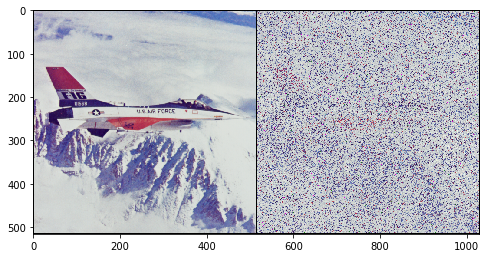

In [50]:
#if fname == 'data/denoising/snail.jpg':
#if fname == 'data/denoising/F16_GT.png':
if HasGT:
    # Add synthetic noise
    img_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_np = pil_to_np(img_pil)
    
    ''' image with noise '''    
    img_noisy_pil, img_noisy_np = get_noisy_image(img_np, sigma_)
    
    if(Requirement1):
        ''' original image '''
        # img_noisy_np = img_np
    
        ''' only noise '''
        # img_noisy_np = np.clip(np.random.uniform(low=0, high=1, size=img_np.shape), 0, 1).astype(np.float32)
        
        ''' shuffle image '''
        x = np.arange(img_np.shape[1])
        np.random.shuffle(x)
        y = np.arange(img_np.shape[2])
        np.random.shuffle(y)
        for i in range(img_np.shape[1]):
            for j in range(img_np.shape[2]):
                x = np.random.randint(0, img_np.shape[1], 2)
                y = np.random.randint(0, img_np.shape[2], 2)
                for k in range(img_np.shape[0]):
                    img_noisy_np[k][x[1]][y[1]] = img_np[k][x[0]][y[0]]
                    img_noisy_np[k][x[0]][y[0]] = img_np[k][x[1]][y[1]]
                    
        '''
        x = np.arange(img_np.shape[1] * img_np.shape[2])
        np.random.shuffle(x)
        for i in range(img_np.shape[1]):
            for j in range(img_np.shape[2]):
                for k in range(img_np.shape[0]):                    
                    img_noisy_np[k][i][j] = img_np[k][x[i * j] / img_np.shape[1]][x[i * j] % img_np.shape[2]]
        '''
    if PLOT:
        plot_image_grid([img_np, img_noisy_np], 4, 6);

else:
    img_noisy_pil = crop_image(get_image(fname, imsize)[0], d=32)
    img_noisy_np = pil_to_np(img_noisy_pil)
    
    # As we don't have ground truth
    img_pil = img_noisy_pil
    img_np = img_noisy_np
    
    if PLOT:
        plot_image_grid([img_np], 4, 5);
        


# Setup

In [51]:
INPUT = 'noise' # 'meshgrid'
pad = 'reflection'
OPT_OVER = 'net' # 'net,input'

reg_noise_std = 1./30. # set to 1./20. for sigma=50
LR = 0.01

OPTIMIZER='adam' # 'LBFGS'
show_every = 500
"""
num_channels_down = [8, 16, 32, 64, 128], 
num_channels_up   = [8, 16, 32, 64, 128],
else:
    assert False
num_channels_skip = [0, 0, 0, 4, 4], 
"""


#if fname == 'data/denoising/F16_GT.png':
if HasGT:
    
    if(Requirement1):
        num_iter = 2400
    else:
        num_iter = 1800
        
    input_depth = 32 
    figsize = 4 
    
    net = get_net(input_depth, 'skip', pad,
                  skip_n33d=128, 
                  skip_n33u=128, 
                  skip_n11=4, 
                  num_scales=5,
                  upsample_mode='bilinear').type(dtype)

else:
    if(Requirement1):
        num_iter = 2400
    else:
        num_iter = 1800
    input_depth = 32
    figsize = 4 
    
    net = skip(
                input_depth, 3, 
                num_channels_down = [128, 128, 128, 128, 128], 
                num_channels_up   = [128, 128, 128, 128, 128], 
                num_channels_skip = [4, 4, 4, 4, 4], 
                upsample_mode='bilinear',
                need_sigmoid=True, need_bias=True, pad=pad, act_fun='LeakyReLU')

    net = net.type(dtype)

    
net_input = get_noise(input_depth, INPUT, (img_pil.size[1], img_pil.size[0])).type(dtype).detach()

# Compute number of parameters
s  = sum([np.prod(list(p.size())) for p in net.parameters()]); 
print ('Number of params: %d' % s)

# Loss
mse = torch.nn.MSELoss().type(dtype)

img_noisy_var = np_to_var(img_noisy_np).type(dtype)

Number of params: 2217831


# Optimize

Starting optimization with ADAM


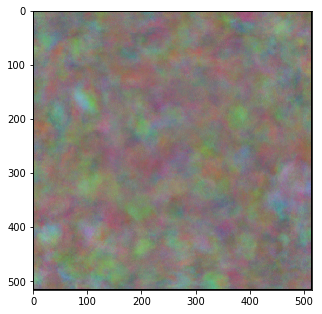

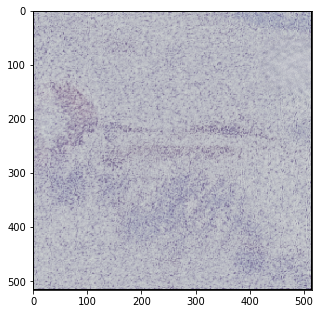

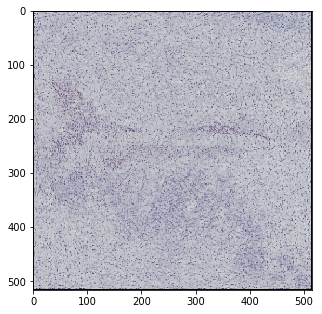

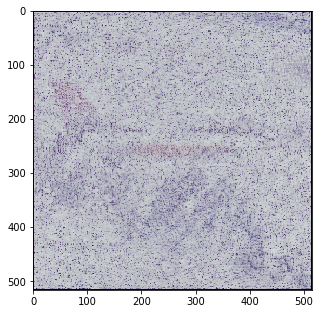

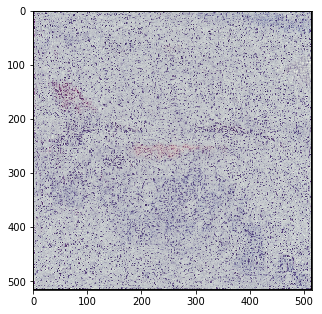

In [52]:
net_input_saved = net_input.data.clone()
noise = net_input.data.clone()


i = 0
my_loss_history = []
def closure():
    
    global i
    global my_loss_history
    
    if reg_noise_std > 0:
        net_input.data = net_input_saved + (noise.normal_() * reg_noise_std)
    
    out = net(net_input)
   
    total_loss = mse(out, img_noisy_var)
    total_loss.backward()
    my_loss_history.append(total_loss.data[0])
        
    print ('Iteration %05d    Loss %f' % (i, total_loss.data[0]), '\r', end='')
    if  PLOT and i % show_every == 0:
        out_np = var_to_np(out)
        plot_image_grid([np.clip(out_np, 0, 1)], factor=figsize, nrow=1)
        
    i += 1

    return total_loss

p = get_params(OPT_OVER, net, net_input)
optimize(OPTIMIZER, p, closure, LR, num_iter)

# PSNR

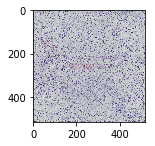

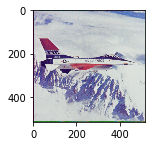

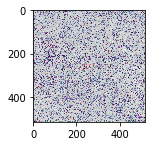

14.422554523955053


In [53]:
out_np = var_to_np(net(net_input))
q = plot_image_grid([np.clip(out_np, 0, 1)], factor=1);
p = plot_image_grid([img_np], factor=1);
r = plot_image_grid([img_noisy_np], factor=1)

import skimage.measure
from scipy import misc

psnr = skimage.measure.compare_psnr(p, q)
print(psnr)

# Save file

0.0900058969855


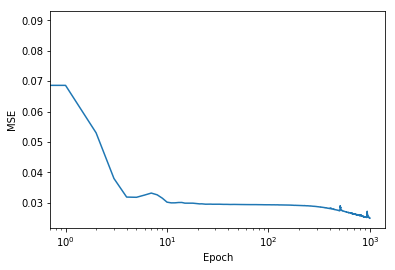

In [54]:
epoch = [i for i in range(2400)]
print(my_loss_history[0])
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.xscale('log')
plt.plot(epoch[0:1000], my_loss_history[0:1000], label="image")
plt.show()

In [55]:
'''
if Requirement1:
    import csv
    f = open('./result/r1_new_shuffle.csv', 'w')
    w = csv.writer(f)
    w.writerows([my_loss_history])
    f.close()
'''

"\nif Requirement1:\n    import csv\n    f = open('./result/r1_new_shuffle.csv', 'w')\n    w = csv.writer(f)\n    w.writerows([my_loss_history])\n    f.close()\n"